# Making Music In Python

### Part 1


In [1]:
import numpy as np

def get_piano_notes():   
    # White keys are in Uppercase and black keys (sharps) are in lowercase
    octave = ['C', 'c', 'D', 'd', 'E', 'F', 'f', 'G', 'g', 'A', 'a', 'B'] 
    base_freq = 440 #Frequency of Note A4
    keys = np.array([x+str(y) for y in range(0,9) for x in octave])
    # Trim to standard 88 keys
    start = np.where(keys == 'A0')[0][0]
    end = np.where(keys == 'C8')[0][0]
    keys = keys[start:end+1]
    
    note_freqs = dict(zip(keys, [2**((n+1-49)/12)*base_freq for n in range(len(keys))]))
    note_freqs[''] = 0.0 # stop
    return note_freqs
    

In [2]:
import numpy as np

def get_sine_wave(frequency, duration, sample_rate=44100, amplitude=4096):
    t = np.linspace(0, duration, int(sample_rate*duration)) # Time axis
    wave = amplitude*np.sin(2*np.pi*frequency*t)
    return wave

In [7]:
import numpy as np
from scipy.io import wavfile

# Get middle C frequency
note_freqs = get_piano_notes()
frequency = note_freqs['C4']

# Pure sine wave
sine_wave = get_sine_wave(frequency, duration=2, amplitude=2048)
wavfile.write('pure_c.wav', rate=44100, data=sine_wave.astype(np.int16))

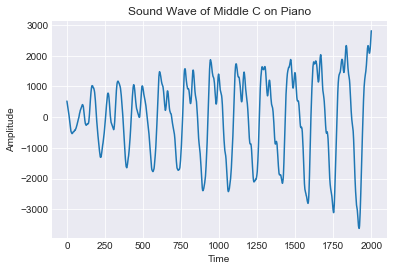

In [9]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

# Load data from wav file
sample_rate, middle_c = wavfile.read('data/piano_c.wav')

# Plot sound wave
plt.plot(middle_c[500:2500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of Middle C on Piano')
plt.grid()

In [13]:
print(middle_c)

[5 5 2 ... 5 5 0]


In [12]:
sample_rate

44100

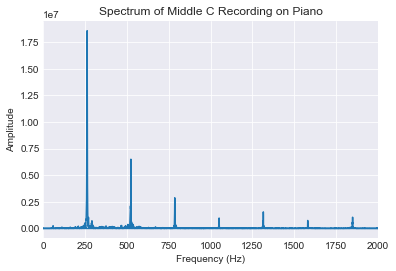

In [14]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

# Load data from wav file
sample_rate, middle_c = wavfile.read('data/piano_c.wav')

#FFT
t = np.arange(middle_c.shape[0])
freq = np.fft.fftfreq(t.shape[-1])*sample_rate
sp = np.fft.fft(middle_c) 

# Plot spectrum
plt.plot(freq, abs(sp.real))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum of Middle C Recording on Piano')
plt.xlim((0, 2000))
plt.grid()

In [15]:
import numpy as np

# Get positive frequency
idx = np.where(freq > 0)[0]
freq = freq[idx]
sp = sp[idx]

# Get dominant frequencies
sort = np.argsort(-abs(sp.real))[:100]
dom_freq = freq[sort]

# Round and calculate amplitude ratio
freq_ratio = np.round(dom_freq/frequency)
unique_freq_ratio = np.unique(freq_ratio)
amp_ratio = abs(sp.real[sort]/np.sum(sp.real[sort]))
factor = np.zeros((int(unique_freq_ratio[-1]), ))
for i in range(factor.shape[0]):
    idx = np.where(freq_ratio==i+1)[0]
    factor[i] = np.sum(amp_ratio[idx])
factor = factor/np.sum(factor)

In [16]:

def apply_overtones(frequency, duration, factor, sample_rate=44100, amplitude=4096):

    assert abs(1-sum(factor)) < 1e-8
    
    frequencies = np.minimum(np.array([frequency*(x+1) for x in range(len(factor))]), sample_rate//2)
    amplitudes = np.array([amplitude*x for x in factor])
    
    fundamental = get_sine_wave(frequencies[0], duration, sample_rate, amplitudes[0])
    for i in range(1, len(factor)):
        overtone = get_sine_wave(frequencies[i], duration, sample_rate, amplitudes[i])
        fundamental += overtone
    return fundamental

# Construct harmonic series
note = apply_overtones(frequency, duration=2.5, factor=factor)

In [18]:
import numpy as np

def get_adsr_weights(frequency, duration, length, decay, sustain_level, sample_rate=44100):

    assert abs(sum(length)-1) < 1e-8
    assert len(length) ==len(decay) == 4
    
    intervals = int(duration*frequency)
    len_A = np.maximum(int(intervals*length[0]),1)
    len_D = np.maximum(int(intervals*length[1]),1)
    len_S = np.maximum(int(intervals*length[2]),1)
    len_R = np.maximum(int(intervals*length[3]),1)
    
    decay_A = decay[0]
    decay_D = decay[1]
    decay_S = decay[2]
    decay_R = decay[3]
    
    A = 1/np.array([(1-decay_A)**n for n in range(len_A)])
    A = A/np.nanmax(A)
    D = np.array([(1-decay_D)**n for n in range(len_D)])
    D = D*(1-sustain_level)+sustain_level
    S = np.array([(1-decay_S)**n for n in range(len_S)])
    S = S*sustain_level
    R = np.array([(1-decay_R)**n for n in range(len_R)])
    R = R*S[-1]
    
    weights = np.concatenate((A,D,S,R))
    smoothing = np.array([0.1*(1-0.1)**n for n in range(5)])
    smoothing = smoothing/np.nansum(smoothing)
    weights = np.convolve(weights, smoothing, mode='same')
    
    weights = np.repeat(weights, int(sample_rate*duration/intervals))
    tail = int(sample_rate*duration-weights.shape[0])
    if tail > 0:
        weights = np.concatenate((weights, weights[-1]-weights[-1]/tail*np.arange(tail)))
    return weights

In [19]:
import numpy as np
from scipy.io import wavfile

# Get sound wave
note = apply_overtones(frequency, duration=2.5, factor=factor)

# Apply smooth ADSR weights
weights = get_adsr_weights(frequency, duration=2.5, length=[0.05, 0.25, 0.55, 0.15],
                           decay=[0.075,0.02,0.005,0.1], sustain_level=0.1)

# Write to file
data = note*weights
data = data*(4096/np.max(data)) # Adjusting the Amplitude 
wavfile.write('synthetic_c.wav', sample_rate, data.astype(np.int16))

### Part 2

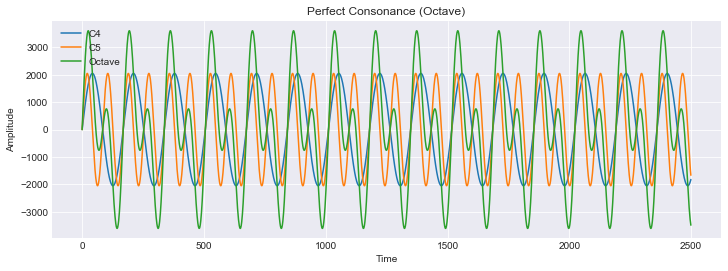

In [23]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

# Get frequency of notes
note_freqs = get_piano_notes()
C4 = get_sine_wave(note_freqs['C4'], 2, amplitude=2048)  # Middle C
C5 = get_sine_wave(note_freqs['C5'], 2, amplitude=2048)  # C one octave above

# Plot
plt.figure(figsize=(12,4))
plt.plot(C4[:2500], label='C4')
plt.plot(C5[:2500], label='C5')
plt.plot((C4+C5)[:2500], label='Octave')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Perfect Consonance (Octave)')
plt.grid()
plt.legend()

In [28]:
C4

array([   0.        ,   76.32305686,  152.54007653, ..., 2043.34338985,
       2047.06787444, 2047.94832544])

In [25]:
def apply_pedal(note_values, bar_value):
    # Check that we have whole number of bars
    assert sum(note_values) % bar_value == 0
    new_values = []
    start = 0
    while True:
        # Count total duration from end of last bar
        cum_value = np.cumsum(np.array(note_values[start:]))
        # Find end of this bar
        end = np.where(cum_value == bar_value)[0][0]
        if end == 0: # If the note takes up the whole bar
            new_values += [note_values[start]]
        else:
            this_bar = np.array(note_values[start:start+end+1])
            # New value of note is the remainder of bar = (total duration of bar) - (cumulative duration thus far)
            new_values += [bar_value-np.sum(this_bar[:i]) for i in range(len(this_bar))]
        start += end+1
        if start == len(note_values):
            break
    return new_values

In [20]:
def get_song_data(music_notes, note_values, bar_value, factor, length,
                  decay, sustain_level, sample_rate=44100, amplitude=4096):
    # Get note frequencies
    note_freqs = get_piano_notes()
    frequencies = [note_freqs[note] for note in music_notes]
    # Get new note durations with sustain applied
    new_values = apply_pedal(note_values, bar_value)
    # End of each note without sustain
    end_idx = np.cumsum(np.array(note_values)*sample_rate).astype(int)
    # Start of each note
    start_idx = np.concatenate(([0], end_idx[:-1]))
    # End of note with sustain
    end_idx = np.array([start_idx[i]+new_values[i]*sample_rate for i in range(len(new_values))]).astype(int)
    
    # Total duration of the piece
    duration = int(sum(note_values)*sample_rate)    
    song = np.zeros((duration,))
    for i in range(len(music_notes)):
        # Fundamental + overtones
        this_note = apply_overtones(frequencies[i], new_values[i], factor)
        # ADSR model
        weights = get_adsr_weights(frequencies[i], new_values[i], length, 
                                   decay, sustain_level)
        song[start_idx[i]:end_idx[i]] += this_note*weights

    song = song*(amplitude/np.max(song))
    return song

In [36]:
import numpy as np
from scipy.io import wavfile


# Define scale and piano characteristics
scale = ['C4','D4','E4','F4','G4','A4','B4','C5']
note_values = [0.5]*8
factor = [0.68, 0.26, 0.03, 0.  , 0.03]
length = [0.01, 0.6, 0.29, 0.1]
decay = [0.05,0.02,0.005,0.1]
sustain_level = 0.1

# Without sustain (each note in separate bar)
scale_plain = get_song_data(scale, note_values, bar_value=0.5,
                                 factor=factor, length=length, decay=decay, 
                                 sustain_level=sustain_level)
scale_plain = scale_plain * (4096/np.max(scale_plain))
wavfile.write('data/scale_plain.wav', 44100, scale_plain.astype(np.int16))

# With sustain (all note in one bar)
scale_sustain = get_song_data(scale, note_values, bar_value=4,
                                 factor=factor, length=length, decay=decay, 
                                 sustain_level=sustain_level)
scale_sustain = scale_sustain * (4096/np.max(scale_sustain))
wavfile.write('data/scale_sustain.wav', 44100, scale_sustain.astype(np.int16))

In [37]:
# Define scale and piano characteristics
scale = ['C4','G4','A4','E4']
note_values = [0.5]*8
factor = [0.68, 0.26, 0.03, 0.  , 0.03]
length = [0.01, 0.6, 0.29,    0.1]
decay = [0.05,0.02,0.005,0.1]
sustain_level = 0.1

# With sustain (all note in one bar)
scale_sustain = get_song_data(scale, note_values, bar_value=4,
                                 factor=factor, length=length, decay=decay, 
                                 sustain_level=sustain_level)
scale_sustain = scale_sustain * (4096/np.max(scale_sustain))
wavfile.write('data/scale_try.wav', 44100, scale_sustain.astype(np.int16))